In [1]:
import pandas as pd
import numpy as np
import random

import quantlib
import quantlib.indicators_cal as indicators_cal
import quantlib.diagnostics_utils as diagnostics_utils

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_instruments_from_df(df):
    instruments = []
    for col in df.columns:
        inst = col.split(" ")[0]
        if "USD" in inst and inst not in instruments:
            instruments.append(inst)
    return instruments

origin_df = pd.read_excel("../crypto_historical_4h.xlsx", engine="openpyxl", index_col='open_time')

In [3]:
look_ahead = 15
look_back = 62
periods = [look_ahead, look_back]
IGNORES = 5 # We do not want to count the closest momentum for possible reversion

instruments = get_instruments_from_df(origin_df)
remove_instruments = []

df = origin_df.copy()
for inst in instruments:
    for p in periods:
        df["{} {} ret".format(inst, p)] = df["{} close".format(inst)].shift(IGNORES) / df["{} close".format(inst)].shift(p+IGNORES) - 1
        df["{} {} fwd ret".format(inst, p)] = df["{} close".format(inst)].shift(-p) / df["{} close".format(inst)] - 1

for inst in instruments:
    if df[f"{inst} {periods[0]} fwd ret"].iloc[0] == 0:
        remove_instruments.append(inst)
    if df[f"{inst} active"].iloc[-2] == False:
        print (inst)
        remove_instruments.append(inst)

df_cols = [col for col in df.columns if col.split(" ")[0] not in remove_instruments]
df = df[df_cols]

SRMUSDT
HNTUSDT
CVCUSDT
BTSUSDT
BTCSTUSDT
SCUSDT
RAYUSDT
FTTUSDT
ANCBUSD
AUCTIONBUSD


In [4]:
x = list(df.columns)
x = [i.split()[1:] for i in x]
x

[['open'],
 ['high'],
 ['low'],
 ['close'],
 ['quote_volume'],
 ['count'],
 ['taker_buy_quote_volume'],
 ['open'],
 ['high'],
 ['low'],
 ['close'],
 ['quote_volume'],
 ['count'],
 ['taker_buy_quote_volume'],
 ['open'],
 ['high'],
 ['low'],
 ['close'],
 ['quote_volume'],
 ['count'],
 ['taker_buy_quote_volume'],
 ['open'],
 ['high'],
 ['low'],
 ['close'],
 ['quote_volume'],
 ['count'],
 ['taker_buy_quote_volume'],
 ['open'],
 ['high'],
 ['low'],
 ['close'],
 ['quote_volume'],
 ['count'],
 ['taker_buy_quote_volume'],
 ['open'],
 ['high'],
 ['low'],
 ['close'],
 ['quote_volume'],
 ['count'],
 ['taker_buy_quote_volume'],
 ['open'],
 ['high'],
 ['low'],
 ['close'],
 ['quote_volume'],
 ['count'],
 ['taker_buy_quote_volume'],
 ['open'],
 ['high'],
 ['low'],
 ['close'],
 ['quote_volume'],
 ['count'],
 ['taker_buy_quote_volume'],
 ['open'],
 ['high'],
 ['low'],
 ['close'],
 ['quote_volume'],
 ['count'],
 ['taker_buy_quote_volume'],
 ['open'],
 ['high'],
 ['low'],
 ['close'],
 ['quote_volume'],
 

In [5]:
target_instruments = [x for x in instruments if x not in remove_instruments]

def set_rank_df(periods, index, rank_df, target_df, instruments):
    for inst in instruments:
        for p in periods:
            rank_df.loc[index, f"{inst} {p} ret"] = target_df.loc[index, f"{inst} {p} ret"]
            rank_df.loc[index, f"{inst} {p} fwd ret"] = target_df.loc[index, f"{inst} {p} fwd ret"]
            rank_df.loc[index, f"{inst} % ret vol"] = target_df.loc[index, f"{inst} % ret vol"]
            ret = target_df.loc[index-p-IGNORES:index-IGNORES, f"{inst} % ret"]
            #ret = target_df.loc[index-p-IGNORES:, f"{inst} % ret"]
            #count = target_df.loc[index-IGNORES, f"{inst} count"]
            #rank_df.loc[index, f"{inst} {p} max bar ret"] = (max(ret) - 0.5*min(ret)) * 100 / count
            #rank_df.loc[index, f"{inst} {p} max bar ret"] = max(ret) + 0.1*min(ret)
            rank_df.loc[index, f"{inst} {p} max bar ret"] = ret.std()
    return rank_df

def get_momentum_rank(df, rebalance_period=10):
    instruments = get_instruments_from_df(df)
    target_df = df.copy().reset_index()
    rank_df = pd.DataFrame()
    for i in target_df.index:
        if i % rebalance_period == 1 and i != 1:
            rank_df = set_rank_df(periods, i, rank_df, target_df, instruments)

    rank_df = rank_df.dropna(axis=0).reset_index(drop=True)
    return rank_df

rank_df = get_momentum_rank(df, look_ahead)

In [6]:
rank_df

,BTCUSDT 15 ret,BTCUSDT 15 fwd ret,BTCUSDT % ret vol,BTCUSDT 15 max bar ret,BTCUSDT 62 ret,BTCUSDT 62 fwd ret,BTCUSDT 62 max bar ret,ETHUSDT 15 ret,ETHUSDT 15 fwd ret,ETHUSDT % ret vol,...,DODOBUSD 62 ret,DODOBUSD 62 fwd ret,DODOBUSD 62 max bar ret,OPUSDT 15 ret,OPUSDT 15 fwd ret,OPUSDT % ret vol,OPUSDT 15 max bar ret,OPUSDT 62 ret,OPUSDT 62 fwd ret,OPUSDT 62 max bar ret
0,-0.048950,0.060206,0.012427,0.011082,0.030040,0.142919,0.014305,-0.074250,0.217673,0.016027,...,0.042449,0.211078,0.024859,-0.134309,0.127585,0.025494,0.022123,-0.125947,0.994339,0.021302
1,0.049922,0.027223,0.014075,0.015029,0.067468,-0.005627,0.014183,0.138267,0.130612,0.026110,...,0.216306,-0.152963,0.025181,0.045720,0.387333,0.029581,0.032367,-0.079008,0.585634,0.024722
2,0.062762,0.065806,0.019263,0.015675,0.000466,0.103028,0.013380,0.201165,0.045414,0.029252,...,0.212481,0.119469,0.025181,0.451927,0.082394,0.060116,0.051420,0.153416,1.108559,0.036131
3,0.049322,-0.021584,0.023000,0.024428,0.111475,0.007472,0.017233,0.029233,0.016537,0.028667,...,0.107303,0.196732,0.025835,-0.022692,0.186447,0.061914,0.060002,0.285285,1.121512,0.044956
4,-0.042857,-0.078639,0.014751,0.015666,0.141995,0.028803,0.017805,0.000434,-0.149330,0.024063,...,0.232299,0.082411,0.023398,0.248686,-0.161808,0.052876,0.054765,0.866216,0.888154,0.049841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,-0.033467,-0.030678,0.020496,0.020161,0.338408,-0.022015,0.021210,-0.025169,-0.037604,0.018802,...,0.422886,-0.156873,0.040668,-0.037647,-0.101625,0.030568,0.030156,0.356100,-0.134881,0.044551
102,0.007777,-0.002921,0.018694,0.014304,0.109290,0.019005,0.015866,0.006126,0.019331,0.017812,...,-0.091339,0.028487,0.032586,-0.109439,0.007673,0.026139,0.024853,-0.180380,0.018532,0.031309
103,-0.012155,0.011717,0.010204,0.011387,0.026480,0.021662,0.015574,-0.017131,0.005024,0.011311,...,-0.088154,0.092144,0.031742,-0.081362,0.007214,0.020298,0.020217,-0.184126,0.013314,0.028545
104,0.055994,0.007226,0.011361,0.008398,0.050095,0.025038,0.014874,0.052253,-0.007679,0.010432,...,-0.147190,0.106509,0.027066,0.100958,-0.036827,0.022570,0.017591,-0.118021,-0.010036,0.024233


In [7]:
k=5
k2=4

portfolio_df = pd.DataFrame(index=rank_df.index, columns=target_instruments)
target_ret_cols = [f"{inst} {look_back} ret" for inst in target_instruments]
target_fwd_ret_cols = [f"{inst} {look_ahead} fwd ret" for inst in target_instruments]
target_ret_vol_cols = [f"{inst} % ret vol" for inst in target_instruments]
target_max_ret_cols = [f"{inst} {look_back} max bar ret" for inst in target_instruments]


for i in rank_df.index:
    momentum_rank = pd.qcut(rank_df.loc[i, target_ret_cols], k, labels=False)
    max_ret_rank = pd.qcut(rank_df.loc[i, target_max_ret_cols], k2, labels=False)
    
    for inst in target_instruments:
        inst_momentum_rank = int(momentum_rank[f"{inst} {look_back} ret"])
        inst_max_ret_rank = int(max_ret_rank[f"{inst} {look_back} max bar ret"])
        portfolio_df.at[i, inst] = [inst_momentum_rank, inst_max_ret_rank]

#print (portfolio_df)

    # for col in target_ret_cols:
    #     portfolio_df.loc[i, col] = int(momentum_rank[col])

    # for col in target_fwd_ret_cols:
    #     portfolio_df.loc[i, col] = rank_df.loc[i, col]


def lookup_ret(index, rank_portfolio):
    fwd_ret_cols = []
    ret_cols = []
    ret_vol_cols = []
    for inst in rank_portfolio:
        for col in target_fwd_ret_cols:
            if inst in col: fwd_ret_cols.append(col)
        for col in target_ret_cols:
            if inst in col: ret_cols.append(col)
        for col in target_ret_vol_cols:
            if inst in col: ret_vol_cols.append(col)
    
    ret_vols = 1 / (rank_df.loc[index, ret_vol_cols] + 0.01)
    ret_vols_percent = ret_vols / ret_vols.sum()
    #ret_vols_percent = [0]
    if sum(ret_vols_percent) == 0:
        inst_fwd_ret = rank_df.loc[index, fwd_ret_cols].mean()
    else:
        inst_fwd_ret = np.average(rank_df.loc[index, fwd_ret_cols], weights=ret_vols_percent)
    inst_ret = rank_df.loc[index, ret_cols].mean()
    inst_ret_vol = rank_df.loc[index, ret_vol_cols].mean()
    return inst_fwd_ret, inst_ret, inst_ret_vol
        

rank_cols = [f"{x}, {y}" for x in range(k) for y in range(k2)]
result_df = pd.DataFrame(index=portfolio_df.index, columns=rank_cols)

for i in portfolio_df.index:
    result_df.loc[i, rank_cols] = [[] for _ in range(k*k2)]
    for col in target_ret_cols:
        inst = col.split(" ")[0]
        rank1, rank2 = portfolio_df.loc[i, inst]
        result_df.loc[i, f"{rank1}, {rank2}"].append(inst)


for i in result_df.index:
    for rank in result_df[rank_cols]:
        rank_portfolio = result_df.loc[i, rank]
        inst_fwd_ret, inst_ret, inst_ret_vol = lookup_ret(i, rank_portfolio)
        result_df.loc[i, f"rank {rank} fwd ret"] = inst_fwd_ret
        result_df.loc[i, f"rank {rank} ret"] = inst_ret
        result_df.loc[i, f"rank {rank} ret vol"] = inst_ret_vol


result_df.fillna(0, inplace=True)

fwd_ret_values = result_df[[f"rank {x}, {y} fwd ret" for x in range(k) for y in range(k2)]]
ranks = pd.Series([f"{x}, {y}" for x in range(k) for y in range(k2)]).reset_index(drop=True)

fwd_ret = fwd_ret_values.mean().reset_index(drop=True)
std = fwd_ret_values.std().reset_index(drop=True)
ret = result_df[[f"rank {x}, {y} ret" for x in range(k) for y in range(k2)]].mean().reset_index(drop=True)
fwd_ret_sharpe = fwd_ret / std * np.sqrt(253)

compare_df = pd.concat({f"{look_back} Return": ret, 
                        f"{look_ahead} Forward Return": fwd_ret,
                        "Sharpe": fwd_ret_sharpe},
                   axis=1)
compare_df = compare_df.apply(lambda x: x*100)
compare_df['Sharpe'] /= 100
compare_df["Rank"] = ranks

compare_df


,62 Return,15 Forward Return,Sharpe,Rank
0,-5.325475,0.005650,0.016239,"0, 0"
1,-8.477901,0.207959,0.506558,"0, 1"
2,-8.929271,0.259513,0.547018,"0, 2"
3,-11.919186,1.198689,2.594981,"0, 3"
4,-3.556721,0.050892,0.146439,"1, 0"
5,-3.646338,0.555611,1.347649,"1, 1"
6,-3.510547,0.808913,1.725511,"1, 2"
7,-4.675828,0.360014,0.779165,"1, 3"
8,-0.627373,0.385046,1.104270,"2, 0"
9,-0.638351,0.345010,0.842998,"2, 1"


In [26]:
long_ranks = ['0, 3', '4, 0', '4, 1']
lw = [0.3, 0.6, 0.1]
long_portfolio = [result_df[f"rank {x} fwd ret"] for x in long_ranks]
long_portfolio = sum([long_portfolio[i]*lw[i] for i in range(len(long_ranks))])


short_ranks = ['0, 0', '1, 0', '4, 2', '4, 3']
sw = [0.25, 0.25, 0.25, 0.25]
short_portfolio = [result_df[f"rank {x} fwd ret"] for x in short_ranks]
short_portfolio = sum([short_portfolio[i]*sw[i] for i in range(len(short_ranks))])


#short_pct = long_portfolio.apply(lambda x: 0.8 if x == 0 else 0.6)
short_pct = 0.68
leverage = 1
SLIPPERAGE = 0.001

Sharpe ratio: 3.643680755991865
Max drawdown: -6.033672086509567%


<Axes: >

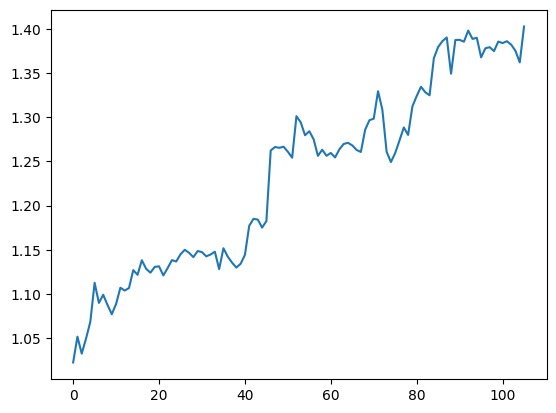

In [27]:
# long-short
result_df["portfolio ret"] = (long_portfolio - short_pct*short_portfolio - SLIPPERAGE*(1+short_pct)) / (1+short_pct) * leverage
sharpe = result_df["portfolio ret"].mean() / result_df["portfolio ret"].std() * np.sqrt(253)

result_df["portfolio ret"] = (1+result_df["portfolio ret"]).cumprod()
result_df["drawdown"] = result_df["portfolio ret"] / result_df["portfolio ret"].cummax() - 1
max_drawdown = result_df["drawdown"].min()*100
print (f"Sharpe ratio: {sharpe}")
print (f"Max drawdown: {max_drawdown}%")
result_df["portfolio ret"].plot()

Sharpe ratio: 2.5949805649478423
Max drawdown: -42.34568457811015%


<Axes: >

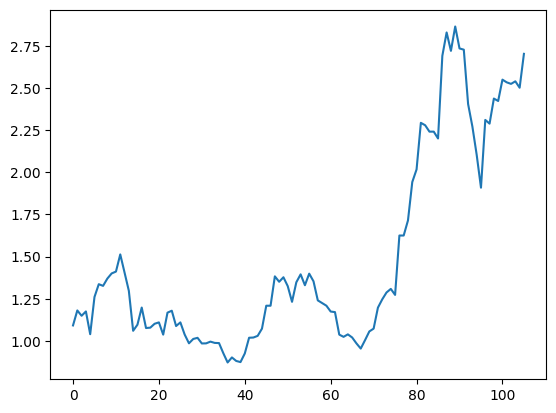

In [15]:
# long only
#result_df["portfolio ret"] = long_portfolio
result_df["portfolio ret"] = result_df[f"rank {'0, 3'} fwd ret"]
sharpe = result_df["portfolio ret"].mean() / result_df["portfolio ret"].std() * np.sqrt(253)

result_df["portfolio ret"] = (1+result_df["portfolio ret"]).cumprod()
result_df["drawdown"] = result_df["portfolio ret"] / result_df["portfolio ret"].cummax() - 1
max_drawdown = result_df["drawdown"].min()*100
print (f"Sharpe ratio: {sharpe}")
print (f"Max drawdown: {max_drawdown}%")
result_df["portfolio ret"].plot()

In [236]:
# IGNORES = 5
# look back, look ahead = 10, 50
# k=5, k2=3
# Shape 

# look back 15, very good also
"""
LONG_RANK = [(0, 3), (1, 3), (3, 3), (3, 2), (4, 0)]
lw = [0.3, 0.1, 0.1, 0.1, 0.4]
SHORT_RANK = [(0, 0), (0, 1), (0, 2), (1, 0), (4, 3)]
sw = [0.5, 0.1, 0.1, 0.2, 0.1]
"""

"""
4h: lookback=40, lookahead=20, k=20, IGNORE=1
sharpe: 5.64
"""
long_symbols = pd.concat([result_df[rank] for rank in long_ranks])
long_symbols.to_csv('long_symbols.csv')

In [30]:
import pandas as pd

df = pd.read_excel("../crypto_historical_4h.xlsx", engine="openpyxl", index_col='open_time')

look_back = 40
look_ahead = 20
IGNORES = 0 # We do not want to count the closest momentum for possible reversion


In [43]:
def get_instruments_from_df(df):
    instruments = []
    for col in df.columns:
        inst = col.split(" ")[0]
        if "USD" in inst and inst not in instruments:
            instruments.append(inst)
    return instruments

instruments = get_instruments_from_df(df)
ret_cols = []

for inst in instruments:
    ret_col_name = "{} {} ret".format(inst, look_back)
    ret_cols.append(ret_col_name)
    df["{} {} ret".format(inst, look_back)] = df["{} close".format(inst)].shift(IGNORES) / df["{} close".format(inst)].shift(look_back+IGNORES) - 1

last = df[ret_cols].tail(1).reset_index(drop=True)
for col in last.columns:
    if last.loc[0, col] == 0:
        ret_cols.remove(col)
rank = pd.qcut(last.loc[0, ret_cols], 20, labels=False)
last

,BTCUSDT 40 ret,ETHUSDT 40 ret,BCHUSDT 40 ret,XRPUSDT 40 ret,EOSUSDT 40 ret,LTCUSDT 40 ret,TRXUSDT 40 ret,ETCUSDT 40 ret,LINKUSDT 40 ret,XLMUSDT 40 ret,...,HOOKUSDT 40 ret,MAGICUSDT 40 ret,TUSDT 40 ret,RNDRUSDT 40 ret,HIGHUSDT 40 ret,MINAUSDT 40 ret,ASTRUSDT 40 ret,AGIXUSDT 40 ret,GMXUSDT 40 ret,CFXUSDT 40 ret
0,0.14464,0.144934,0.176087,0.070787,0.236275,0.077025,0.096128,0.138361,0.234618,0.100654,...,0.135678,0.302268,0.188522,0.170271,0.279631,0.097142,0.2322,-0.148812,-0.013008,NaN


In [44]:
long_list, short_list = [], []
for col in ret_cols:
    symbol = col.split(" ")[0]
    if rank[col] == 0:
        short_list.append(symbol)
    elif rank[col] == 19:
        long_list.append(symbol)

print ("Long list: ", long_list)
print ("Short list: ", short_list)

Long list:  ['IOSTUSDT', 'BLZUSDT', 'FILUSDT', 'DENTUSDT', 'MTLUSDT', 'NKNUSDT', 'KLAYUSDT', 'STGUSDT']
Short list:  ['MKRUSDT', 'BTCDOMUSDT', 'FOOTBALLUSDT', '1000LUNCUSDT', 'LUNA2USDT', 'APTUSDT', 'AGIXUSDT', 'GMXUSDT']


In [39]:
from brokerage.binance.TradeClient import TradeClient

client = TradeClient()
for symbol in long_list:
    pass

open_time
2023-02-20 08:00:00    0.0
Name: FTTUSDT 40 ret, dtype: float64